In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt

In [2]:
myFile = uproot.open('testing_testfiles.root')

In [3]:
tree = myFile['TestTree']

In [4]:
eventId = tree.array('eventId')
pfoId = tree.array('pfoId')
driftPos = tree.array('hitDriftPositionsW')
wirePos = tree.array('hitWirePositionsW')
pdg = tree.array('bestMCParticlePdgCode')
isTrack = tree.array('bestMCParticleIsTrack')
completeness = tree.array('completeness')
purity = tree.array('purity')
nHitsW = tree.array('nHitsInPfoW')
nHitsU = tree.array('nHitsInPfoU')
nHitsV = tree.array('nHitsInPfoV')
vertexdriftPos = tree.array('vertexDriftPosition')
vertexwirePos = tree.array('vertexWirePositionW')
hitEnergiesW = tree.array('hitEnergiesW')
particles = len(pfoId)

# Calculation of energy

## Get identities of good pfos

In [5]:
comppureid = np.intersect1d(np.where(completeness > 0.89),np.where(purity > 0.89))
goodhits = []
for i in range(particles):
    if len(wirePos[i]) > 5:
        goodhits.append(i)
trueid = np.intersect1d(comppureid,goodhits)

## Regress the lines of best fit

In [6]:
#Find means in wire and drift for each pfo
wireav = wirePos[trueid].mean()
driftav = driftPos[trueid].mean()

#Find slope and intercept of lines of best fit
driftdiff = driftPos[trueid] - driftav
wirediff = wirePos[trueid] - wireav
driftwire = driftdiff*wirediff
driftsq = driftdiff**2
nume = driftwire.sum()
denom = driftsq.sum()
slope = nume/denom
intercept = wireav - slope*driftav
slopezero = np.where(slope==0.0)

In [7]:
slopezero = np.where(slope==0.0)
for i in slopezero:
    slope = np.delete(slope,i)
    intercept =np.delete(intercept,i)
    trueid = np.delete(trueid,i)

## First and last points of each pfo

In [8]:
wirePos_sorted = []
driftPos_sorted = []

for i in range(len(wirePos)):
    wirePos_sorted.append(np.sort(wirePos[i]))
    
for i in range(len(driftPos)):
    driftPos_sorted.append(np.sort(driftPos[i]))

In [9]:
wirePosstart = []
wirePosend = []
driftPosstart = []
driftPosend = []
for i in trueid:
    wirePosstart.append(wirePos_sorted[i][0])
    wirePosend.append(wirePos_sorted[i][-1])
    driftPosstart.append(driftPos_sorted[i][0])
    driftPosend.append(driftPos_sorted[i][-1])

In [10]:
## First and last points of each pfo

wirePos_sorted = []
driftPos_sorted = []

for i in range(len(wirePos)):
    wirePos_sorted.append(np.sort(wirePos[i]))
    
for i in range(len(driftPos)):
    driftPos_sorted.append(np.sort(driftPos[i]))

wirePosstart = []
wirePosend = []
driftPosstart = []
driftPosend = []
for i in trueid:
    wirePosstart.append(wirePos_sorted[i][0])
    wirePosend.append(wirePos_sorted[i][-1])
    driftPosstart.append(driftPos_sorted[i][0])
    driftPosend.append(driftPos_sorted[i][-1])

## Regress end points to line of best fit

In [11]:
xstart = []
xend = []
ystart = []
yend = []
for i in range(len(trueid)):
    if slope[i] != 0:
        slopeinv = -1.0/slope[i]
        startintercept = wirePosstart[i] - driftPosstart[i]*slopeinv
        endintercept = wirePosend[i] - driftPosend[i]*slopeinv
        xbegin = (startintercept - intercept[i])/(slope[i] - slopeinv)
        ybegin = slope[i]*xbegin + intercept[i]
        xfinish = (endintercept - intercept[i])/(slope[i]-slopeinv)
        yfinish = slope[i]*xfinish + intercept[i]
        xstart.append(xbegin)
        xend.append(xfinish)
        ystart.append(ybegin)
        yend.append(yfinish)
    else:
        xstart.append(driftPosstart[i])
        xend.append(driftPosend[i])
        ystart.append(wirePosstart[i])
        yend.append(wirePosend[i])
        

# Line lengths

In [12]:
linelength = []
for i in range(len(xstart)):
    xdiff = xend[i] - xstart[i]
    ydiff = yend[i] - ystart[i]
    lensq = xdiff**2 +ydiff**2
    length = np.sqrt(lensq)
    linelength.append(length)

# Regress all pfo points to line gosh this took 5ever

In [13]:
xpoints = []
ypoints = []
for i in range(len(trueid)):
    xcoord = []
    ycoord = []
    a = trueid[i]
    if slope[i] == 0.0:
        xcoord.append(driftPos[a])
        ycoord.append(wirePos[a])
    else:
        for j in range(len(wirePos[a])):
            slopeinv = -1.0/slope[i]
            pointintercept = wirePos[a][j] - driftPos[a][j]*slopeinv
            xpoint = (pointintercept - intercept[i])/(slope[i] - slopeinv)
            ypoint = slope[i]*xpoint + intercept[i]
            xcoord.append(xpoint)
            ycoord.append(ypoint)
    xpoints.append(xcoord)
    ypoints.append(ycoord)

# Normalise positions of regressed points for banter

In [14]:
pointsnorm = []
for i in range(len(trueid)):
    pointcoordnorm = []
    for j in range(len(xpoints[i])):
        xdifference = xpoints[i][j] - xpoints[i][0]
        lengf = xpoints[i][-1] - xpoints[i][0]
        normlength = xdifference/lengf
        pointcoordnorm.append(normlength)
    pointsnorm.append(pointcoordnorm)

# Order those regressed points along the line praise be to argsort

In [15]:
pointorder = []
for i in range(len(trueid)):
    lengthorder = np.argsort(pointsnorm[i])
    pointorder.append(lengthorder)

# Reorganise regressed points according to position, not gender or race

In [16]:
xpointsorder = []
ypointsorder = []
for i in range(len(trueid)):
    xpfosort = [xpoints for _,xpoints in sorted(zip(pointorder[i],xpoints[i]))]
    ypfosort = [ypoints for _,ypoints in sorted(zip(pointorder[i],ypoints[i]))]
    xpointsorder.append(xpfosort)
    ypointsorder.append(ypfosort)

# Find new lengths due to reordered points.

In [17]:
truelinelength = []
for i in range(len(xstart)):
    xdiff = xpointsorder[i][-1] - xpointsorder[i][0]
    ydiff = ypointsorder[i][-1] - ypointsorder[i][0]
    lensq = xdiff**2 + ydiff**2
    length = np.sqrt(lensq)
    truelinelength.append(length)

# Find new normalised point positions 

In [18]:
truepointsnorm = []
for i in range(len(trueid)):
    truepointcoordnorm = []
    a = trueid[i]
    for j in range(len(xpointsorder[i])):
        xdifference = xpointsorder[i][j] - xpointsorder[i][0]
        ydifference = ypointsorder[i][j] - ypointsorder[i][0]
        lengthsq = xdifference**2 + ydifference**2
        truelen = np.sqrt(lengthsq)
        normlength = truelen/truelinelength[i]
        truepointcoordnorm.append(normlength)
    truepointsnorm.append(truepointcoordnorm)

# Energy of hits > 0.8 along the line

In [19]:
end_indices = []

for i in range(len(truepointsnorm)):
    indices_end = np.where(np.array(truepointsnorm[i]) > 0.8)
    end_indices.append(indices_end[0])

In [20]:
pfo_energies = hitEnergiesW[trueid]

In [21]:
total_pfo_energies_sum = pfo_energies.sum()

In [22]:
end_pfo_energies = []

for i in range(len(trueid)):
    end_pfo_energies.append(pfo_energies[i][end_indices[i]])

In [23]:
end_pfo_energies_sum = []

for i in range(len(trueid)):
    end_pfo_energies_sum.append(end_pfo_energies[i].sum())

In [24]:
energy_frac = end_pfo_energies_sum / total_pfo_energies_sum

# Calculation of angles

# Calculate means

In [25]:
drift_pos_av = driftPos.mean()
wire_pos_av = wirePos.mean()

# Calculate gradient

In [26]:
drift_comp = driftPos - drift_pos_av
wire_comp = wirePos - wire_pos_av
drift_comp_sq = drift_comp ** 2
numerator = (drift_comp * wire_comp).sum()
denominator = (drift_comp_sq).sum()
m = numerator / denominator
c = wire_pos_av - m * drift_pos_av

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [27]:
len(vertexwirePos)

326107

In [28]:
select_wirePos = wirePos[trueid]

select_driftPos = driftPos[trueid]

select_vertexwirePos = vertexwirePos[trueid]

select_vertexdriftPos = vertexdriftPos[trueid]

m_trueid = m[trueid]

c_trueid = c[trueid]

In [29]:
len(vertexdriftPos)

326107

# Plot regression lines

In [30]:
y_values = []
m_values = []
c_values = []


for i in range(len(trueid)):
    y = m_trueid[i]*select_driftPos[i] + c_trueid[i]
    
#     fig = plt.figure(figsize = (10, 15))
#     plt.scatter(select_driftPos[i], select_wirePos[i], color = 'b', s = 1)
#     plt.plot(select_driftPos[i], y, color = 'r', linewidth = 3) 


    y_values.append(y)
    m_values.append(m_trueid[i])
    c_values.append(c_trueid[i])

# Get first x and y values for each PFO regression line

In [31]:
first_y = []
first_x = []
last_x = []
last_y = []

for i in range(len(trueid)):
    
    origin_x = select_driftPos[i][0]
    
    origin_y = (m_values[i] * select_driftPos[i][0]) + c_values[i]
    
    end_x = select_driftPos[i][-1]
    
    end_y = (m_values[i] * select_driftPos[i][-1]) + c_values[i]
    
    first_y.append(origin_y)
    
    first_x.append(origin_x)
    
    last_y.append(end_y)
    
    last_x.append(end_x)

# Regression line vector

In [32]:
d_zero = ((select_vertexwirePos - first_y) ** 2) + ((select_vertexdriftPos - first_x) ** 2)
d_end = ((select_vertexwirePos - last_y) ** 2) + ((select_vertexdriftPos - last_x) ** 2)

In [33]:
x_sinc = []
y_sinc = []

x_origin = []
y_origin = []

for i in range(len(trueid)):
    
    origin_x, origin_y = (first_x[i], first_y[i]) if d_zero[i] < d_end[i] else (last_x[i], last_y[i])
    
    x_origin.append(origin_x)
    
    y_origin.append(origin_y)
    
    sinc_x, sinc_y = (first_x[i], first_y[i]) if d_zero[i] >= d_end[i] else (last_x[i], last_y[i])
    
    x_sinc.append(sinc_x)
    
    y_sinc.append(sinc_y)

In [34]:
x_line_vector = np.array(x_sinc) - np.array(x_origin)
y_line_vector = np.array(y_sinc) - np.array(y_origin)

In [35]:
mag_line = np.sqrt((x_line_vector ** 2) + (y_line_vector ** 2))

# Hit vector

In [36]:
x_hit_vector = select_driftPos - x_origin
y_hit_vector = select_wirePos - y_origin

In [37]:
mag_hit = np.sqrt((x_hit_vector ** 2) + (y_hit_vector ** 2))

# Calculate angle

In [38]:
theta_num = (x_line_vector * x_hit_vector) + (y_line_vector * y_hit_vector)
theta_denom = mag_line * mag_hit
theta = theta_num / theta_denom

In [39]:
angle = np.degrees(np.arccos(theta))
av_theta = (angle.mean())

C:\Users\r.xavier\Anaconda3\lib\site-packages\awkward\array\jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Compute probabilties using PDFs

In [40]:
energies_tracks = np.load('energies_tracks_pdf.npy')
energies_showers = np.load('energies_showers_pdf.npy')
angles_tracks = np.load('angles_tracks_pdf.npy')
angles_showers = np.load('angles_showers_pdf.npy')

In [144]:
bin_num_energies = []

for i in range(len(energy_frac)):
    bin_num_energies.append((int(round(energy_frac[i] * 500))))

In [145]:
energy_prob_tracks = []

for i in range(len(energy_frac)):
     energy_prob_tracks.append(energies_tracks[0][bin_num_energies[i]])

In [147]:
energy_prob_showers = []

for i in range(len(energy_frac)):
     energy_prob_showers.append(energies_showers[0][bin_num_energies[i]])

In [161]:
bin_num_angles = []

for i in range(len(av_theta)):
    bin_num_angles.append((int(round(av_theta[i] * 500)/180)))

In [162]:
angle_prob_tracks = []

for i in range(len(av_theta)):
    angle_prob_tracks.append(angles_tracks[0][bin_num_angles[i]])

In [163]:
angle_prob_showers = []

for i in range(len(av_theta)):
    angle_prob_showers.append(angles_showers[0][bin_num_angles[i]])

In [175]:
p_track = np.array(energy_prob_tracks) * np.array(angle_prob_showers)
p_shower = np.array(energy_prob_showers) * np.array(angle_prob_showers)

# LIKELIHOOD 

In [176]:
l = p_track/(p_track+p_shower)

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


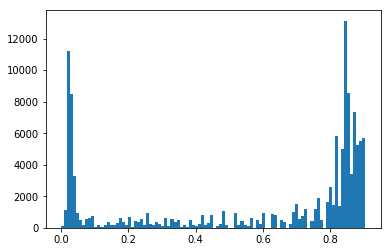

In [178]:
plt.hist(l, 100)
plt.show()